In [1]:
import os
import yaml
import numpy as np
from math import sqrt,log10
import pylab as plt
from scipy.optimize import brentq, fmin
from scipy.interpolate import interp1d as interp
from scipy.interpolate import UnivariateSpline as spline
from sklearn.model_selection import LeaveOneOut
%matplotlib inline

In [28]:
L, a, b, c, r = np.load('../results/mcmc/MCtest_1e4.npy')

In [21]:
sortL = np.argsort(L)[::-1]
for par in ['L', 'a', 'b', 'c', 'r']:
    exec( "{p} = {p}[sortL]".format(p=par) )

In [22]:
indLmin = np.where( L==min(L) )[0]
Lmin = L[indLmin][0]

In [23]:
cutL = L < int(Lmin)+20
for par in ['L', 'a', 'b', 'c', 'r']:
    exec( "{p} = {p}[cutL]".format(p=par) )
indLmin = np.where( L==min(L) )[0][0]

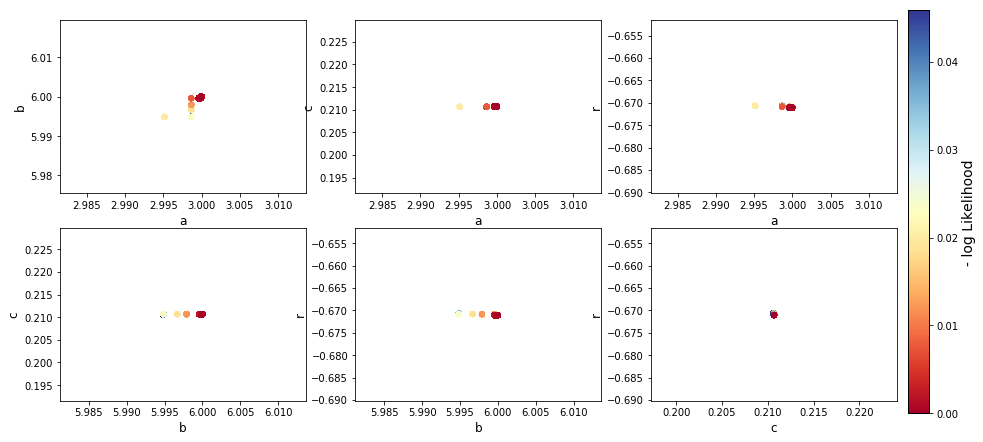

In [18]:
cm = plt.cm.get_cmap('RdYlBu')
pairs = [('a','b'), ('a','c'), ('a','r'), ('b','c'), ('b','r'), ('c','r')]
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,7))
for dat, ax in zip(pairs, axes.flat):
    # The vmin and vmax arguments specify the color limits
    exec('xvalues = {}'.format(dat[0]) )
    exec('yvalues = {}'.format(dat[1]) )
    sc = ax.scatter( xvalues, yvalues, c=L-min(L), cmap=cm, lw=0 );
    ax.set_xlabel(dat[0], fontsize=12);
    ax.set_ylabel(dat[1], fontsize=12);
    cax = fig.add_axes([0.91, 0.1, 0.02, 0.8])
    cbar = fig.colorbar(sc, cax=cax);
    cbar.ax.set_ylabel('- log Likelihood', fontsize=14)
#plt.savefig('results/Like_Mc_scatterplots.png', dpi=300, format='png');

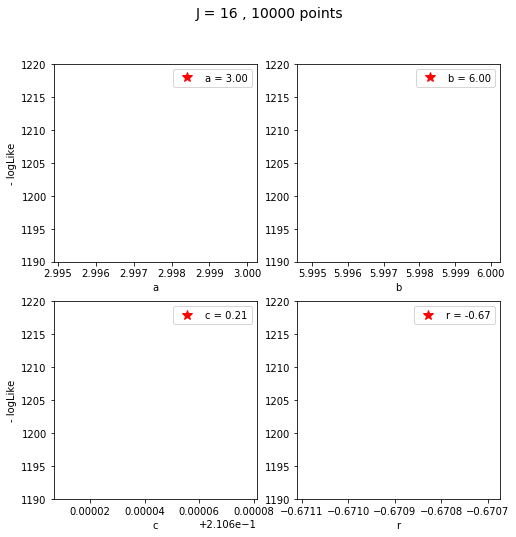

In [13]:
fig = plt.figure(figsize=(8,8))
for i,par in enumerate(['a', 'b', 'c', 'r']):
    ax = fig.add_subplot(2,2,i+1)
    ax.plot( eval('{}'.format(par)), L, 'bo', alpha=0.2  );
    exec( 'parmin = {}[indLmin]'.format(par) )
    ax.plot( parmin, Lmin, 'r*', ms=10, label= '%s = %.2f'%(par, parmin) );
    ax.set_xlabel(par);
    if i%2 == 0: 
        ax.set_ylabel('- logLike')
    ax.set_ylim(1190, 1220);
    ax.legend(numpoints=1);
plt.suptitle('J = 16 , 10000 points', fontsize=14);
#plt.savefig('../results/mcmc/Like_Mc10000_16_zoom.png', dpi=300, format='png');

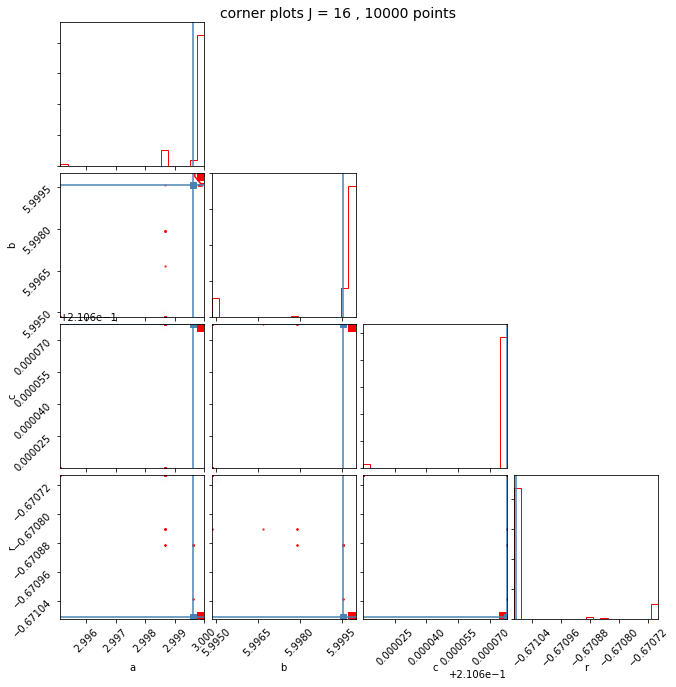

In [15]:
samples = np.array([a, b, c, r]).T
from corner import corner
tmp = corner(samples, labels=['a', 'b', 'c', 'r'], color='red',
            truths=[a[indLmin], b[indLmin], c[indLmin], r[indLmin]])
plt.suptitle('corner plots J = 16 , 10000 points', fontsize=14);
#plt.savefig('../results/mcmc/corner_J16_1e4_zoom.png', dpi=300);

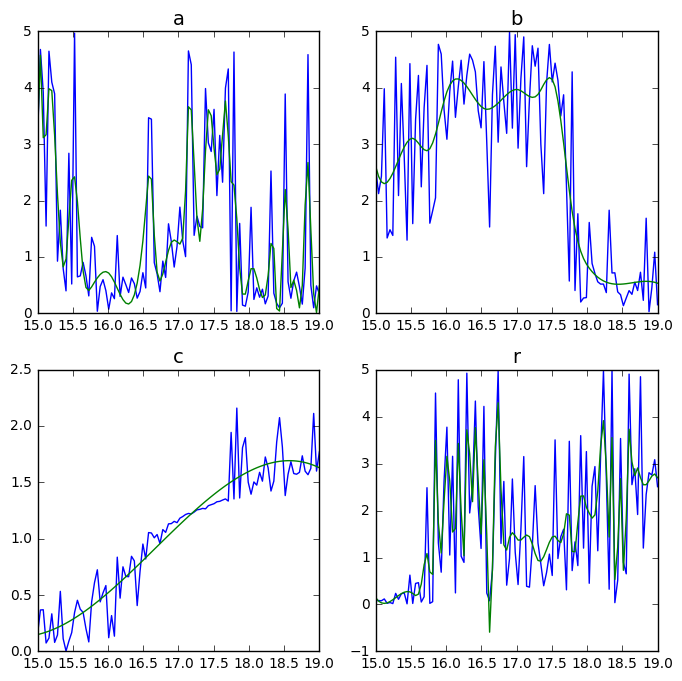

In [85]:
fig = plt.figure(figsize=(8,8))
for i,p in enumerate(['a', 'b', 'c', 'r']):
    ax = fig.add_subplot(2,2,i+1)
    ax.plot(J, eval( '{}'.format(p) ) );
    ax.plot(J, eval( 'spl_{}(J)'.format(p) ) );
    ax.set_title(p, fontsize=14);

In [86]:
for i,c in enumerate([0.5,2.0,4.5]):
    exec('J%ssL = %.2f'%(i+1, brentq(lambda j : spline_L(j)-spline_L(J).min()-c, min(J), Jmin) - Jmin))
    exec('J%ssR = %.2f'%(i+1, brentq(lambda j : spline_L(j)-spline_L(J).min()-c, Jmin, max(J)) - Jmin))

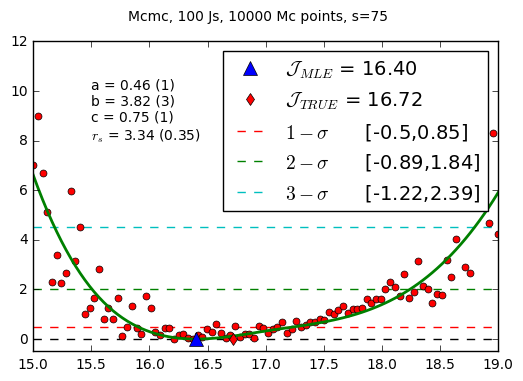

In [87]:
lin = linear_L(J)
spl = spline_L(J)
plt.plot(J, L-L.min(), 'ro', ms=5);
#plt.plot(J, lin-lin.min(), 'bo', ms=5);
plt.plot(J, spl-spl.min(), 'g', lw=2);

plt.hlines(0, min(J), max(J), linestyles='dashed')
plt.plot(Jmin, 0, 'b^', markersize=10, label=r'$\mathcal{J}_{MLE}$ = %.2f'%Jmin)
plt.plot(16.72, 0, 'rd', markersize=6, label=r'$\mathcal{J}_{TRUE}$ = 16.72')
for i,(c,h) in enumerate(zip(['r','g','c'],[0.5,2.0,4.5])):
    JL, JR = eval('J%ssL'%str(i+1)), eval('J%ssR'%str(i+1))
    plt.hlines(h, J_plt.min(), J_plt.max(), linestyles='dashed', colors=c,
              label=r'$%i-\sigma$'%(i+1)+'\t'+'[%2s,%2s]'%(str(JL),str(JR)))
plt.legend(numpoints=1,fontsize=14).get_frame().set_facecolor('w')
plt.text(15.5, 8,'a = %.2f (1)'%Ja +'\n'+
                 'b = %.2f (3)'%Jb +'\n'+
                 'c = %.2f (1)'%Jc +'\n'+
                 r'$r_s$ = %.2f (0.35)'%Jr)

plt.ylim(-0.5,12);
plt.suptitle("Mcmc, 100 Js, 10000 Mc points, s=%i"%s);
#plt.savefig('results/LikeJ_Mc10000_rabc_100p_CVs.png',format='png',dpi=300);

In [57]:
from scipy.stats import binned_statistic

Lmins = binned_statistic(J, L, statistic='min', bins=20)[0]

indxmins = np.where( [L==lm for lm in Lmins] )[1]

In [58]:
RSS = []
for s in smoothing:
    score = []
    for train, test in LOOCV.split(J[indxmins], L[indxmins]):
        spline_L = spline(J[train], L[train], s=s)
        score.append( (J[test] - spline_L(J[test]))**2 )
    RSS.append( sum(score) )

mins = np.where( RSS==min(RSS) )[0][0]

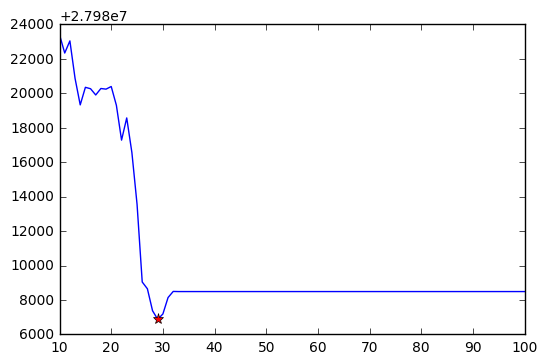

In [59]:
plt.plot(smoothing, RSS);
plt.plot(smoothing[mins], RSS[mins], 'r*', ms=8);

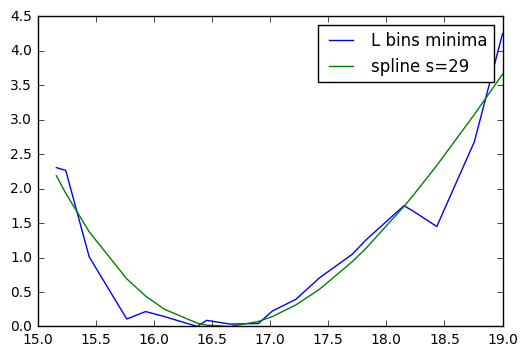

In [60]:
spline_mins = spline(J[indxmins], L[indxmins], s=smoothing[mins])
splminsL = spline_mins( J[indxmins] )
plt.plot(J[indxmins], L[indxmins]-min(L[indxmins]), label='L bins minima' );
plt.plot(J[indxmins], splminsL-min(splminsL), label='spline s=%g'%smoothing[mins] );
plt.legend();
#plt.savefig('results/envelope.png', dpi=300, format='png');

In [61]:
min_splnmins = spline_mins(eval_Like_J).min()
Jminspl = eval_Like_J[ np.where( spline_mins(eval_Like_J) == min_splnmins )[0][0] ]

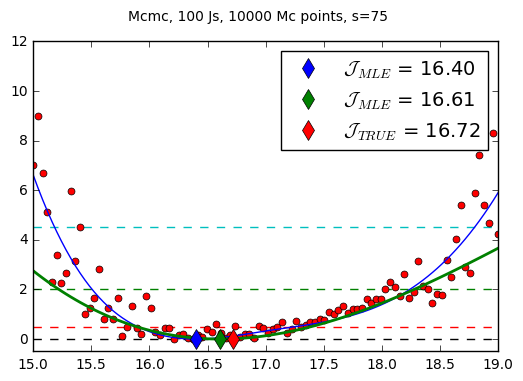

In [63]:
splmins = spline_mins(J)
plt.plot(J, L-L.min(), 'ro', ms=5);
#plt.plot(J, lin-min(lin), 'bo', ms=5);
plt.plot(J, spl-min(spl), 'b', lw=1);
plt.plot(J, splmins-min(splmins), 'g', lw=2);

plt.hlines(0, min(J), max(J), linestyles='dashed')
plt.plot(Jmin, 0, 'bd', markersize=10, label=r'$\mathcal{J}_{MLE}$ = %.2f'%Jmin)
plt.plot(Jminspl, 0, 'gd', markersize=10, label=r'$\mathcal{J}_{MLE}$ = %.2f'%Jminspl)
plt.plot(16.72, 0, 'rd', markersize=10, label=r'$\mathcal{J}_{TRUE}$ = 16.72')
for i,(c,h) in enumerate(zip(['r','g','c'],[0.5,2.0,4.5])):
    JL, JR = eval('J%ssL'%str(i+1)), eval('J%ssR'%str(i+1))
    plt.hlines(h, J_plt.min(), J_plt.max(), linestyles='dashed', colors=c,)
              #label=r'$%i-\sigma$'%(i+1)+'\t'+'[%2s,%2s]'%(str(JL),str(JR)))
plt.legend(numpoints=1,fontsize=14).get_frame().set_facecolor('w')
'''plt.text(15.5, 8,'a = %.2f (1)'%Ja +'\n'+
                 'b = %.2f (3)'%Jb +'\n'+
                 'c = %.2f (1)'%Jc +'\n'+
                 r'$r_s$ = %.2f (0.35)'%Jr)
'''
plt.ylim(-0.5,12);
plt.suptitle("Mcmc, 100 Js, 10000 Mc points, s=%i"%res);
#plt.savefig('results/LikeJ_Mc_envelope2.png',format='png',dpi=300);

In [30]:
Jminspl

16.493493493493492

In [98]:
LOOCV = LeaveOneOut()

In [99]:
def RSS(smoothing, X, Y):
    RSS = []
    for s in smoothing:
        score = []
        for train, test in LOOCV.split(X, Y):
            spline_L = spline(X[train], Y[train], s=s)
            score.append( (X[test] - spline_L(X[test]))**2 )
        RSS.append( sum(score) )
    return RSS

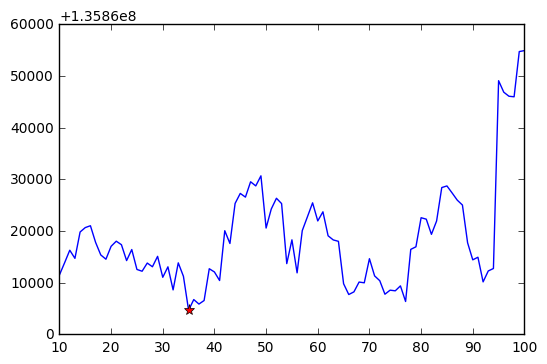

In [100]:
smoothing = range(10,101)
RSSL = RSS(smoothing, J, L)

mins = np.where( RSSL==min(RSSL) )[0][0]

plt.plot(smoothing, RSSL);
plt.plot(smoothing[mins], RSSL[mins], 'r*', ms=8);

In [101]:
S = smoothing[mins]
linear_L = interp(J, L)
spline_L = spline(J, L, s=S)

#eval_Like_J = np.linspace(min(J), max(J), 1e3)
#min_Like_J = min(spline_L(eval_Like_J))
#Jmin = eval_Like_J[ np.where( spline_L(eval_Like_J) == min_Like_J )[0][0] ]
J_plt = np.linspace(min(J), max(J))

In [102]:
Jmin = J[ np.where( spline_L(J)==min(spline_L(J)) ) ]

In [103]:
smoothing = range(10,101)
for par in ['a', 'b', 'c', 'r']:
    exec( 'RSSpar = RSS(smoothing, J, {})'.format(par) )
    minspar = np.where( RSSpar==min(RSSpar) )[0][0]
    exec( 'interp_{0} = spline(J, {0}, s=smoothing[minspar])'.format(par))
    exec( 'J{0} = float(interp_{0}(Jmin))'.format(par) )

print 'r = %.2f, a = %.2f, b = %.2f, c = %.2f'%(Jr, Ja, Jb, Jc)

r = 0.28, a = 1.11, b = 3.00, c = 0.98


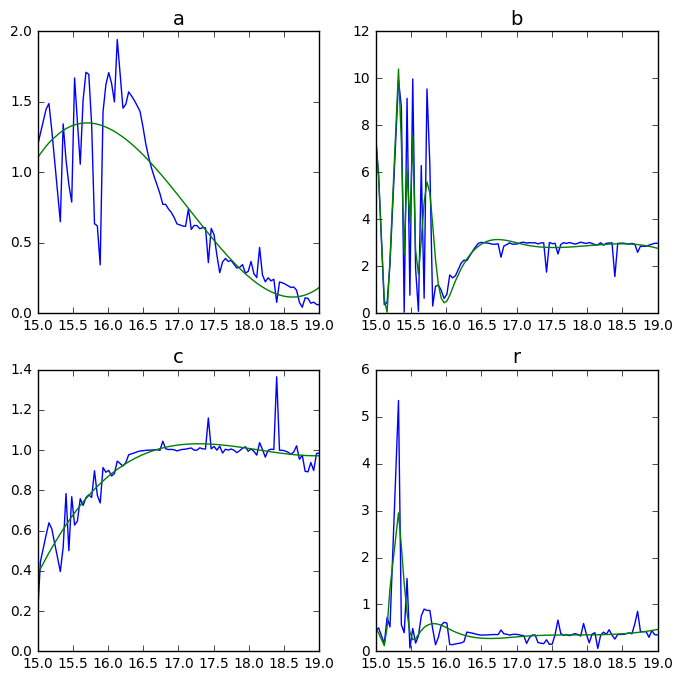

In [104]:
fig = plt.figure(figsize=(8,8))
for i,p in enumerate(['a', 'b', 'c', 'r']):
    ax = fig.add_subplot(2,2,i+1)
    ax.plot(J, eval( '{}'.format(p) ) );
    ax.plot(J, eval( 'interp_{}(J)'.format(p) ) );
    ax.set_title(p, fontsize=14);

In [105]:
for i,c in enumerate([0.5,2.0,4.5]):
    exec('J%ssL = %.2f'%(i+1, brentq(lambda j : spline_L(j)-spline_L(J).min()-c, J.min(), Jmin) - Jmin))
    exec('J%ssR = %.2f'%(i+1, brentq(lambda j : spline_L(j)-spline_L(J).min()-c, Jmin, J.max()) - Jmin))

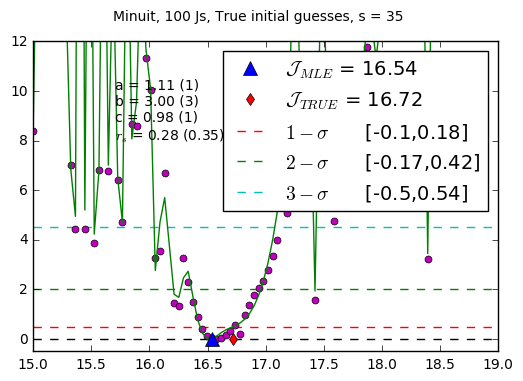

In [115]:
lin = linear_L(J)
spl = spline_L(J)
plt.plot(J, L-L.min(), 'mo', ms=5);
#plt.plot(J, lin-lin.min(), 'b');
plt.plot(J, spl-spl.min(), 'g');

plt.hlines(0, J.min(), J.max(), linestyles='dashed')
plt.plot(Jmin, 0, 'b^', markersize=10, label=r'$\mathcal{J}_{MLE}$ = %.2f'%Jmin)
plt.plot(16.72, 0, 'rd', markersize=6, label=r'$\mathcal{J}_{TRUE}$ = 16.72')
for i,(c,h) in enumerate(zip(['r','g','c'],[0.5,2.0,4.5])):
    JL, JR = eval('J%ssL'%str(i+1)), eval('J%ssR'%str(i+1))
    plt.hlines(h, J_plt.min(), J_plt.max(), linestyles='dashed', colors=c,
              label=r'$%i-\sigma$'%(i+1)+'\t'+'[%2s,%2s]'%(str(JL),str(JR)))
plt.legend(numpoints=1,fontsize=14).get_frame().set_facecolor('w')
plt.text(15.7, 8,'a = %.2f (1)'%Ja +'\n'+
                 'b = %.2f (3)'%Jb +'\n'+
                 'c = %.2f (1)'%Jc +'\n'+
                 r'$r_s$ = %.2f (0.35)'%Jr)

plt.ylim(-0.5,12);
plt.suptitle('Minuit, 100 Js, True initial guesses, s = %g'%S);
#plt.savefig('results/LikeJ_Min_rabc_100p_Tini_lin.png',format='png',dpi=300);

In [68]:
J, L, a, b, c, r = np.load('results/LikeJ1.npy')
linear_L = interp(J, L)

In [69]:
eval_Like_J = np.linspace(J.min(), J.max(), 100)
min_Like_J = linear_L(eval_Like_J).min()
Jmin = eval_Like_J[ np.where( linear_L(eval_Like_J) == min_Like_J )[0][0] ]

In [70]:
for par in ['a', 'b', 'c', 'r']:
    exec( 'spl_{par} = interp(J, {par})'.format(par=par))
    exec( 'J{0} = float(spl_{0}(Jmin))'.format(par) )

In [71]:
for i,c in enumerate([0.5,2.0,4.5]):
    exec('J%ssL = %.2f'%(i+1, brentq(lambda j : linear_L(j)-linear_L(J).min()-c, J.min(), Jmin) - Jmin))
    exec('J%ssR = %.2f'%(i+1, brentq(lambda j : linear_L(j)-linear_L(J).min()-c, Jmin, J.max()) - Jmin))

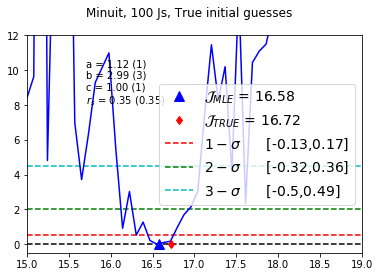

In [73]:
lin = linear_L(J)
plt.plot(J, lin-lin.min(), 'b');

plt.hlines(0, J.min(), J.max(), linestyles='dashed')
plt.plot(Jmin, 0, 'b^', markersize=10, label=r'$\mathcal{J}_{MLE}$ = %.2f'%Jmin)
plt.plot(16.72, 0, 'rd', markersize=6, label=r'$\mathcal{J}_{TRUE}$ = 16.72')
for i,(c,h) in enumerate(zip(['r','g','c'],[0.5,2.0,4.5])):
    JL, JR = eval('J%ssL'%str(i+1)), eval('J%ssR'%str(i+1))
    plt.hlines(h, J.min(), J.max(), linestyles='dashed', colors=c,
              label=r'$%i-\sigma$'%(i+1)+'\t'+'[%2s,%2s]'%(str(JL),str(JR)))
plt.legend(numpoints=1,fontsize=14).get_frame().set_facecolor('w')
plt.text(15.7, 8,'a = %.2f (1)'%Ja +'\n'+
                 'b = %.2f (3)'%Jb +'\n'+
                 'c = %.2f (1)'%Jc +'\n'+
                 r'$r_s$ = %.2f (0.35)'%Jr)

plt.ylim(-0.5,12);
plt.xlim(15, 19);
plt.suptitle('Minuit, 100 Js, True initial guesses');
#plt.savefig('results/LikeJ_Min_rabc_100p_Tini_lin.png',format='png',dpi=300);